Para este ejercicio, usaremos el conjunto de datos tf_flowers de Google y partiremos de la red VGG16. **NOTA:** la red VGG16 no fue entrenada para clasificar diferentes tipos de flores.

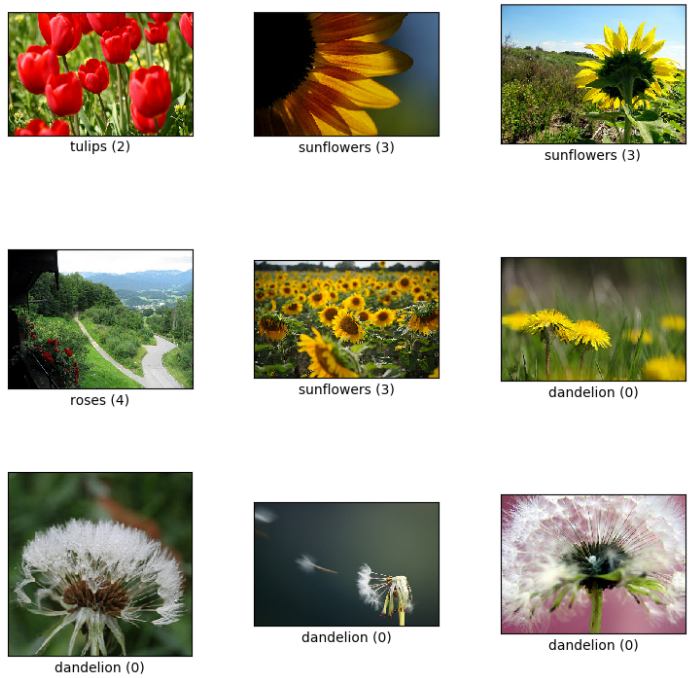

# Dataset de flores

In [ ]:
import os
import glob

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
_URL = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
path_to_zip = tf.keras.utils.get_file('flower_photos.zip', origin=_URL, untar=True)

In [ ]:
# Contenido de la carpeta descomprimida
path_images = os.path.join(os.path.dirname(path_to_zip), 'flower_photos')
print(os.listdir(path_images))

['daisy', 'sunflowers', 'roses', 'LICENSE.txt', 'dandelion', 'tulips']


In [ ]:
# Número de imágenes
image_count = len(list(glob.glob(os.path.join(path_images, '*/*.jpg'))))
print('Numero de imágenes : ', image_count)

Numero de imágenes :  3670


In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (150, 150)

# Dado que no tenemos partición específica de validación, vamos a partir la base de datos en entrenamiento (70%) y validación (30%)
train_dataset = image_dataset_from_directory(path_images,
                                             validation_split=0.3,
                                             subset="training",
                                             seed=123,
                                             image_size=IMG_SIZE,
                                             batch_size=BATCH_SIZE)

validation_dataset = image_dataset_from_directory(path_images,
                                                  validation_split=0.3,
                                                  subset="validation",
                                                  seed=123,
                                                  image_size=IMG_SIZE,
                                                  batch_size=BATCH_SIZE)

Found 3670 files belonging to 5 classes.
Using 2569 files for training.
Found 3670 files belonging to 5 classes.
Using 1101 files for validation.


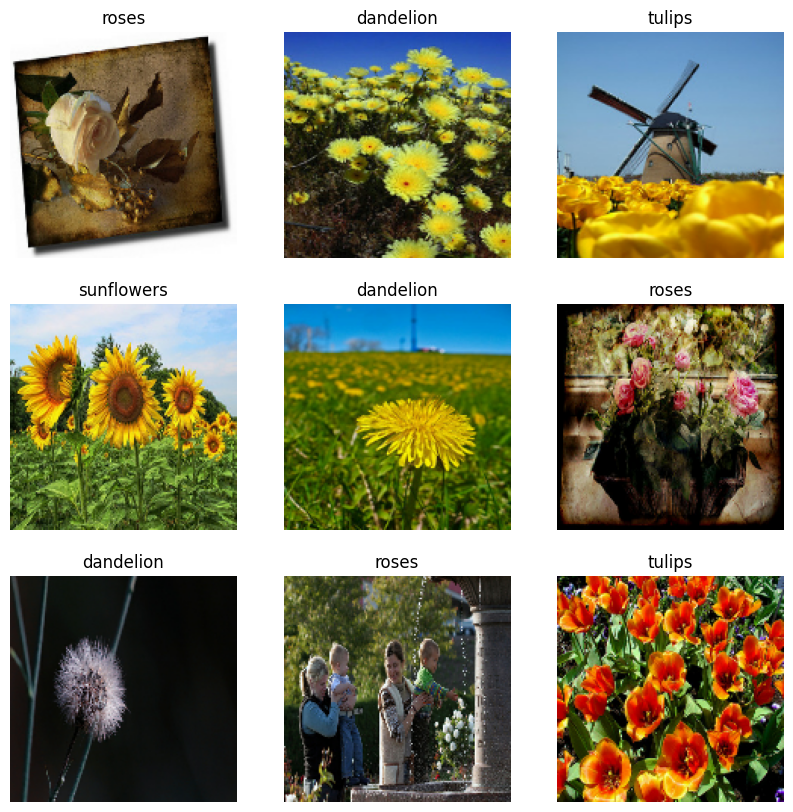

In [ ]:
# Visualizamos el dataset
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
#  Generamos partición de test
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
print('Número de lotes de validación: ', tf.data.experimental.cardinality(validation_dataset).numpy())
print('Número de lotes de test: ', tf.data.experimental.cardinality(test_dataset).numpy())

Número de lotes de validación:  28
Número de lotes de test:  7


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Le añadimos la dimensión de los 3 canales (RGB)
IMG_SHAPE = IMG_SIZE + (3,)


In [ ]:
IMG_SHAPE

(150, 150, 3)

# Red convolucional

Primero vamos a crear una red convolucional desde cero para comparar con VGG16:

**PREGUNTA**

1. Crea una red convolucional con una primera capa de Reescalado 1./255. A continuación:
>* capa convolucional de 16 filtros de tamaño de filtro 3 y pading "same", stride = 2, . Activación "Relu"
>* capa MaxPooling2D
>* capa convolucional de 32 filtros de tamaño de filtro 5 y pading "same". Activación "Relu"
>* capa MaxPooling2D
>* capa convolucional de 32 filtros de tamaño de filtro 5 y pading "same". Activación "Relu"
>* capa MaxPooling2D
>* Flatten
>* Capa densa de 50. Activación "Relu"
>* Capa densa de 20. Activación "Relu"
>* Capa de salidad del tamaño adecuado.




2. Crea un early stopping sobre el accuracy (paciencia 5) y que restaure los mejores pesos

3. Entrena el modelo con 50 épocas como máximo y tamaño de batch 32.

In [ ]:

from tensorflow.keras import Sequential, layers
from tensorflow.keras.callbacks import EarlyStopping, History
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout


In [ ]:
# Defino el imput_shape
input_shape = (150, 150, 3)

# Red convolucional
model = Sequential([
    Rescaling(scale=1./255, input_shape=input_shape),
    Conv2D(16, (3, 3), padding='same', strides=2, activation='relu'),
    MaxPooling2D(),
    Conv2D(32, (5, 5), padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, (5, 5), padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(20, activation='relu'),
    Dense(5, activation='softmax')
])

# Compilación de la red convolucional
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
# Early stopping paciencia 5 con mejores pesos
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)


In [ ]:
history_callback = History()
# Entrenamiento
model.fit(train_dataset, epochs=50, batch_size=32, validation_data = validation_dataset, callbacks=[early_stopping, history_callback])

Epoch 1/50
81/81 [==============================] - 7s 59ms/step - loss: 1.4481 - accuracy: 0.3422 - val_loss: 1.4808 - val_accuracy: 0.3250
Epoch 2/50
81/81 [==============================] - 5s 53ms/step - loss: 1.1847 - accuracy: 0.4951 - val_loss: 1.1974 - val_accuracy: 0.4652
Epoch 3/50
81/81 [==============================] - 6s 68ms/step - loss: 1.0531 - accuracy: 0.5679 - val_loss: 1.0462 - val_accuracy: 0.5587
Epoch 4/50
81/81 [==============================] - 5s 53ms/step - loss: 0.9866 - accuracy: 0.6033 - val_loss: 0.9926 - val_accuracy: 0.5929
Epoch 5/50
81/81 [==============================] - 5s 59ms/step - loss: 0.8988 - accuracy: 0.6563 - val_loss: 0.9115 - val_accuracy: 0.6385
Epoch 6/50
81/81 [==============================] - 5s 56ms/step - loss: 0.8503 - accuracy: 0.6668 - val_loss: 0.9342 - val_accuracy: 0.6385
Epoch 7/50
81/81 [==============================] - 5s 54ms/step - loss: 0.7839 - accuracy: 0.7034 - val_loss: 0.8887 - val_accuracy: 0.6636
Epoch 8/50
81

**PREGUNTA**

4. Evalúa el accuracy del modelo
5. Plotea el accuracy de los modelos de entrenamiento y validación

In [ ]:
import matplotlib.pyplot as plt

# Evaluar el modelo en los datos de entrenamiento y validación
train_loss, train_accuracy = model.evaluate(train_dataset)
val_loss, val_accuracy = model.evaluate(validation_dataset)

print("Exactitud en datos de entrenamiento:", train_accuracy)
print("Exactitud en datos de validación:", val_accuracy)

28/28 [==============================] - 1s 29ms/step - loss: 0.9130 - accuracy: 0.6465
Exactitud en datos de entrenamiento: 0.7177889943122864
Exactitud en datos de validación: 0.6465222239494324


In [ ]:
# Obtener historial de entrenamiento
history = history_callback.history

# Para acceder a las métricas de entrenamiento y validación
train_accuracy = history['accuracy']
val_accuracy = history['val_accuracy']
print(train_accuracy)
print(val_accuracy)

[0.34215646982192993, 0.49513429403305054, 0.5679252743721008, 0.6033475995063782, 0.6562864780426025, 0.6667964458465576, 0.7033865451812744, 0.7185675501823425, 0.7282989621162415, 0.7625535130500793, 0.7890229821205139, 0.8018684387207031]
[0.3249714970588684, 0.4652223587036133, 0.5587229132652283, 0.5929304361343384, 0.638540506362915, 0.638540506362915, 0.6636260151863098, 0.638540506362915, 0.6545040011405945, 0.6624857187271118, 0.6339794993400574, 0.6624857187271118]


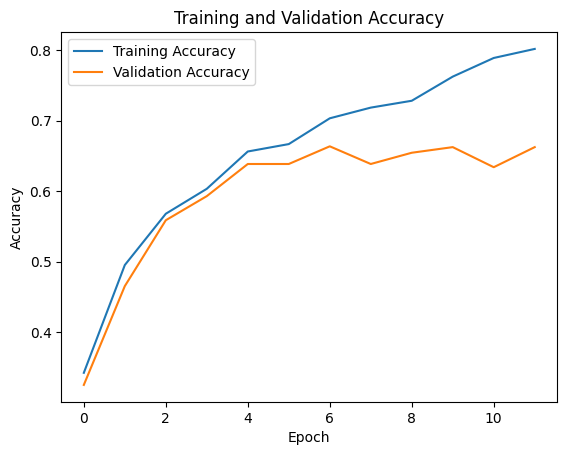

In [ ]:
# Obtener historial de entrenamiento
history = history_callback.history
# Plotear accuracy de entrenamiento y validación
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# VGG16

**PREGUNTA**

6. Carga el modelo VGG16 de Keras y muestra un resumen de sus capas

In [ ]:
from tensorflow.keras.applications import VGG16

# Cargar el modelo VGG16
vgg16_model = VGG16()

# Mostrar un resumen de las capas del modelo
vgg16_model.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

**PREGUNTA**

7. Bloquea su entrenamiento y extrae su capa de preprocesamiento para uso posterior

In [ ]:
from tensorflow.keras.applications import VGG16

# Cargar el modelo VGG16
vgg16_model = VGG16()

# Congelar todas las capas del modelo VGG16
for layer in vgg16_model.layers:
    layer.trainable = False

# Extraer la capa de preprocesamiento
preprocess_layer = vgg16_model.layers[0]

# Mostrar un resumen de las capas del modelo
vgg16_model.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

**PREGUNTA**

8. Crea al método create_cnn_tc() que genera el modelo con preprocesado de vgg16 y al que le añadimos una capa densa de 50 y otra de 20, para finalizar con la capa de salida (softmax). Utiliza Global Average Pooling para unir VGG16 con la red densa. Muestra un resumen

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Flatten, Dense, Dropout

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import VGG16

def create_cnn_tc():
    # Cargar el modelo VGG16 sin incluir la capa de salida
    base_model = VGG16(include_top=False, input_shape=(None, None, 3))

    # Congelar todas las capas del modelo VGG16
    for layer in base_model.layers:
        layer.trainable = False

    # Extraer la capa de preprocesamiento
    preprocess_layer = base_model.layers[0]

    # Conectar el modelo VGG16 con las capas densas
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(50, activation='relu')(x)
    x = Dense(20, activation='relu')(x)
    output = Dense(5, activation='softmax')(x)  # Capa de salida con 5 clases

    # Crear el modelo completo
    model = Model(inputs=preprocess_layer.input, outputs=output)

    return model

# Crear el modelo
cnn_tc_model = create_cnn_tc()

# Mostrar un resumen del modelo
cnn_tc_model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

**PREGUNTA**

9. Crea un early stopping igual al del modelo base y entrena el nuevo modelo (50 épocas) y tamaño de batch 32

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, History

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
history_callback = History()

# Compilacion
cnn_tc_model.compile(optimizer='adam',
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

history = cnn_tc_model.fit(train_dataset, epochs=50, batch_size=32, validation_data=validation_dataset, callbacks=[early_stopping, history_callback])


Epoch 1/50
81/81 [==============================] - 10s 101ms/step - loss: 1.6710 - accuracy: 0.5271 - val_loss: 0.9616 - val_accuracy: 0.6648
Epoch 2/50
81/81 [==============================] - 8s 94ms/step - loss: 0.6802 - accuracy: 0.7571 - val_loss: 0.7915 - val_accuracy: 0.7286
Epoch 3/50
81/81 [==============================] - 8s 95ms/step - loss: 0.4758 - accuracy: 0.8256 - val_loss: 0.7119 - val_accuracy: 0.7662
Epoch 4/50
81/81 [==============================] - 8s 97ms/step - loss: 0.3519 - accuracy: 0.8743 - val_loss: 0.7406 - val_accuracy: 0.7617
Epoch 5/50
81/81 [==============================] - 8s 94ms/step - loss: 0.2695 - accuracy: 0.9027 - val_loss: 0.6852 - val_accuracy: 0.7868
Epoch 6/50
81/81 [==============================] - 8s 97ms/step - loss: 0.2156 - accuracy: 0.9272 - val_loss: 0.7583 - val_accuracy: 0.7799
Epoch 7/50
81/81 [==============================] - 8s 98ms/step - loss: 0.1633 - accuracy: 0.9439 - val_loss: 0.7964 - val_accuracy: 0.7902
Epoch 8/50


**PREGUNTA**

10. Evalua y plotea la exactitud

28/28 [==============================] - 2s 62ms/step - loss: 0.8777 - accuracy: 0.8005
Exactitud en datos de entrenamiento: 0.9945504069328308
Exactitud en datos de validación: 0.8004561066627502


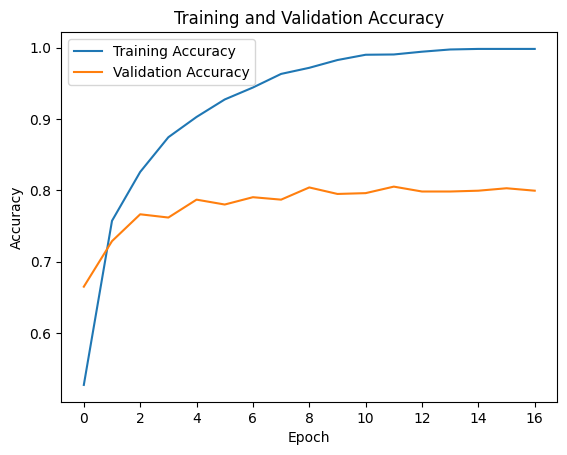

In [ ]:
import matplotlib.pyplot as plt

# Evaluar el modelo en los datos de entrenamiento y validación
train_loss, train_accuracy = cnn_tc_model.evaluate(train_dataset)
val_loss, val_accuracy = cnn_tc_model.evaluate(validation_dataset)

print("Exactitud en datos de entrenamiento:", train_accuracy)
print("Exactitud en datos de validación:", val_accuracy)

# Obtener historial de entrenamiento
history = history_callback.history

# Plotear accuracy de entrenamiento y validación
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
